# 데이터 준비하기

In [ ]:
!pip install tensorflow-addons
!pip install pydot

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa # https://www.tensorflow.org/addons/overview?hl=ko

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model #모델 시각화(https://codetorial.net/tensorflow/visualize_model.html)
import pickle

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteYQ8NK3/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
# 데이터셋 정보
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
# 데이터의 개수
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [ ]:
ds_info.features["label"].num_classes # 라벨 갯수 확인

2

In [ ]:
ds_info.features["label"].names # 라벨 이름 확인

['cat', 'dog']

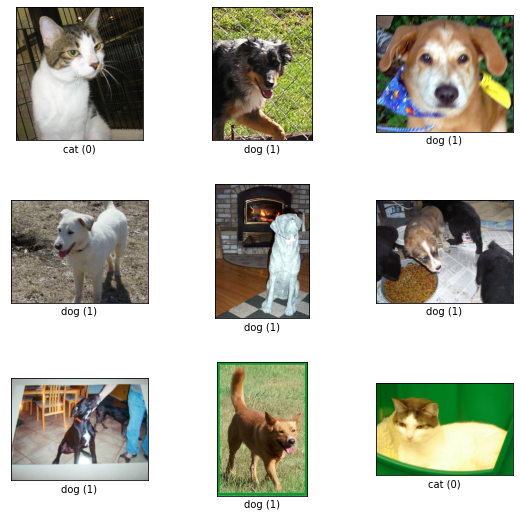

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

# ResNet(34,50) 구현

### Conv 블록 만들기

In [ ]:
# function for building Conv Block

def build_conv_block(input_layer,
                    channel=64,
                    kernel_size = 3,
                    strides = 1,
                    stage_num=1, # 단순 이름
                    unit_num=1, # 단순 이름
                    block_num=1, # 단순 이름
                    activation='relu'
                   ):
    # 입력 레이어
    x = input_layer
    
    
    # CNN 레이어
    x = keras.layers.Conv2D(filters=channel,kernel_size = kernel_size, strides=strides ,padding='same',
                            name=f'stage{stage_num}_{unit_num}_conv{block_num}')(x)    

    # Batch Normal 레이어
    x = keras.layers.BatchNormalization(name = f'stage{stage_num}_{unit_num}_bn{block_num}')(x)
    
    #activation 레이어
    if activation :
        x = keras.layers.Activation(activation = activation, name = f'stage{stage_num}_{unit_num}_relu{block_num}')(x)

    return x

In [ ]:
conv_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
conv_block_output = build_conv_block(conv_input_layer)    # VGG 블록 생성

### Conv 블록 확인

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=conv_input_layer, outputs=conv_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 stage1_1_conv1 (Conv2D)     (None, 32, 32, 64)        1792      
                                                                 
 stage1_1_bn1 (BatchNormaliz  (None, 32, 32, 64)       256       
 ation)                                                          
                                                                 
 stage1_1_relu1 (Activation)  (None, 32, 32, 64)       0         
                                                                 
Total params: 2,048
Trainable params: 1,920
Non-trainable params: 128
_________________________________________________________________


### Residual 블록 만들기

In [ ]:
# function for building Conv Block

def build_residual_block(input_layer,
                    channel=64,
                    stage_num=1,
                    unit_num=1,
                    is_50 = True,
                    is_first = 0):
    # 입력 레이어
    x = input_layer
    
    #ResNet 50
    if is_50 :
        for unit in range(1,unit_num+1):
            if unit == 1 and is_first == 0: 
                short_cut = keras.layers.Conv2D(filters=channel*4, kernel_size=1, strides=1, 
                                                name=f'stage{stage_num}_{unit}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                        
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                short_cut = keras.layers.Conv2D(filters=channel*4, kernel_size=1, strides=2, 
                                                name=f'stage{stage_num}_{unit}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
            else :
                short_cut = x
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                
            x = keras.layers.Add()([x, short_cut])
            x = keras.layers.Activation('relu')(x)
    
    #ResNet 34
    else :
        for unit in range(1,unit_num+1):
            
            if unit == 1 and is_first == 0: 
                short_cut = keras.layers.Conv2D(filters=channel, kernel_size=1, strides=1, 
                                                name=f'stage{stage_num}_{unit_num}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                short_cut = keras.layers.Conv2D(filters=channel, kernel_size=1, strides=2, 
                                                name=f'stage{stage_num}_{unit_num}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
            else :
                short_cut = x
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            x = keras.layers.Add()([x, short_cut])
            x = keras.layers.Activation('relu')(x)
            
    return x

In [ ]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
              unit_num_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              activation = 'softmax',
              is_50 = True,
              name = 'ResNet50'):
    
    assert len(unit_num_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    x = build_conv_block(input_layer=input_layer,channel=64,kernel_size=7,strides=2)
    x = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same',name = 'stage1_1_maxpooling')(x)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (unit_num, channel) in enumerate(zip(unit_num_list, channel_list)):
        
        stage = i+2
        x = build_residual_block(x,channel,stage,unit_num,is_50,i) 
        
    x = keras.layers.GlobalAvgPool2D()(x)
    output = keras.layers.Dense(units=num_classes, activation=activation)(x)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output,
        name=name
    )
    return model

#### ResNet34

In [ ]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
resnet_34 = build_resnet(is_50=False,num_classes = 10,name="ResNet34")

resnet_34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stage1_1_conv1 (Conv2D)        (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 stage1_1_bn1 (BatchNormalizati  (None, 16, 16, 64)  256         ['stage1_1_conv1[0][0]']         
 on)                                                                                              
                                                                                                  
 stage1_1_relu1 (Activation)    (None, 16, 16, 64)   0           ['stage1_1_bn1[0][0]']    

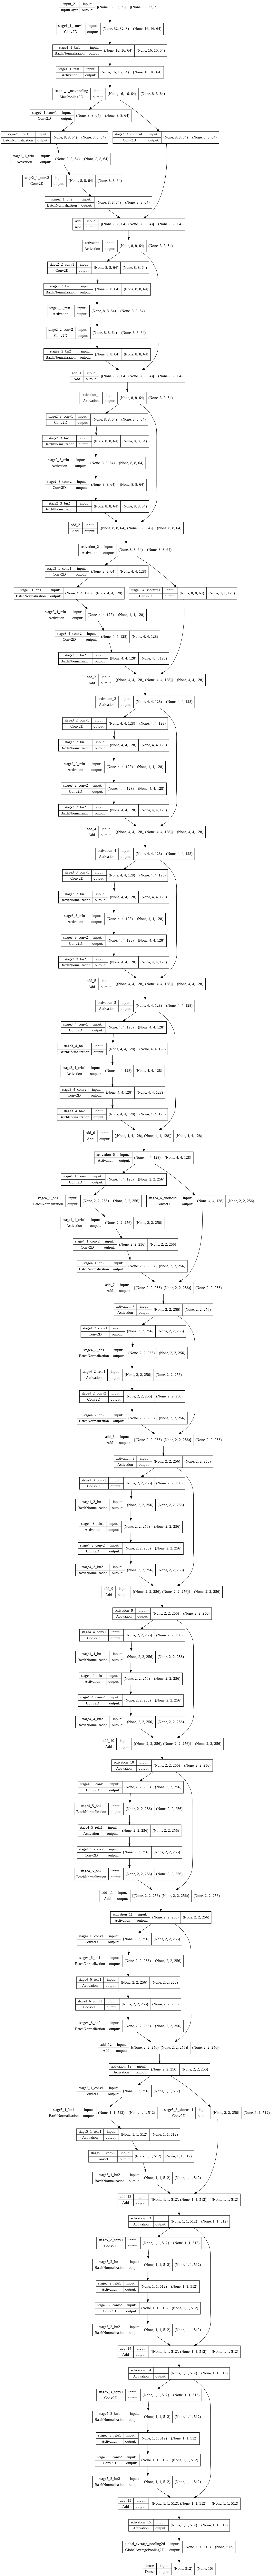

In [ ]:
plot_model(resnet_34, show_shapes=True)

#### ResNet50

In [ ]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
resnet_50 = build_resnet(is_50=True,num_classes = 10,name="ResNet50")

resnet_50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stage1_1_conv1 (Conv2D)        (None, 16, 16, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 stage1_1_bn1 (BatchNormalizati  (None, 16, 16, 64)  256         ['stage1_1_conv1[0][0]']         
 on)                                                                                              
                                                                                                  
 stage1_1_relu1 (Activation)    (None, 16, 16, 64)   0           ['stage1_1_bn1[0][0]']    

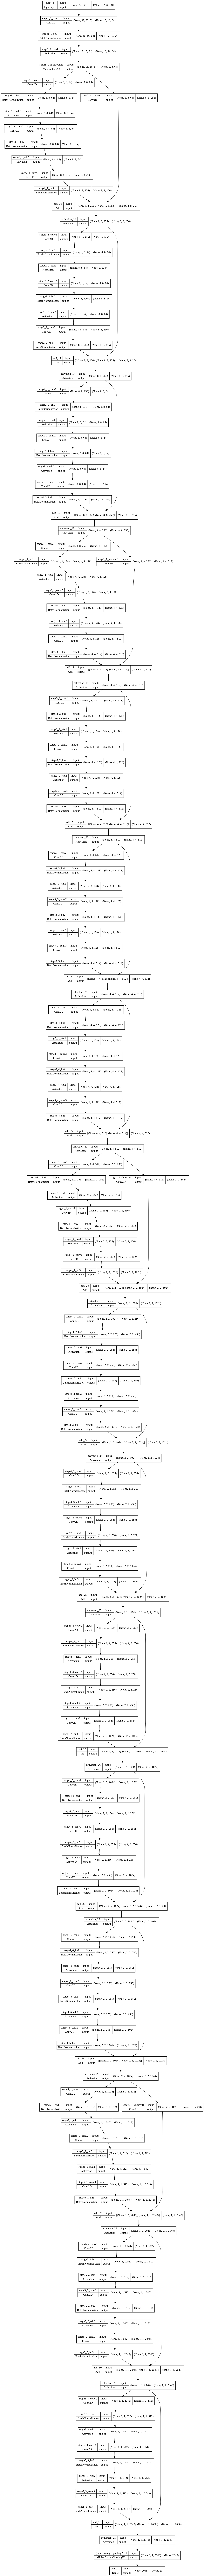

In [ ]:
plot_model(resnet_50, show_shapes=True)

# Plain-model

In [ ]:
# function for building Conv Block

def build_conv_block(input_layer,
                    channel=64,
                    kernel_size = 3,
                    strides = 1,
                    stage_num=1,
                    unit_num=1,
                    block_num=1,
                    activation='relu'
                   ):
    # 입력 레이어
    x = input_layer
    
    
    # CNN 레이어
    x = keras.layers.Conv2D(filters=channel,kernel_size = kernel_size, strides=strides ,padding='same',
                            name=f'stage{stage_num}_{unit_num}_conv{block_num}')(x)    

    # Batch Normal 레이어
    x = keras.layers.BatchNormalization(name = f'stage{stage_num}_{unit_num}_bn{block_num}')(x)
    
    #activation 레이어
    if activation :
        x = keras.layers.Activation(activation = activation, name = f'stage{stage_num}_{unit_num}_relu{block_num}')(x)

    return x

In [ ]:
# function for building Conv Block

def build_plain_block(input_layer,
                    channel=64,
                    stage_num=1,
                    unit_num=1,
                    is_50 = True,
                    is_first = 0):
    # 입력 레이어
    x = input_layer
    
    #ResNet 50
    if is_50 :
        for unit in range(1,unit_num+1):
            if unit == 1 and is_first == 0: 
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                        
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
            else :
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                
            x = keras.layers.Activation('relu')(x)
    
    #ResNet 34
    else :
        for unit in range(1,unit_num+1):
            
            if unit == 1 and is_first == 0: 
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
            else :
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            x = keras.layers.Activation('relu')(x)
            
    return x

In [ ]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_plain_resnet(input_shape=(32,32,3),
              unit_num_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              is_50 = True,
              activation = 'softmax',
              name = 'ResNet50'):
    
    assert len(unit_num_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    x = build_conv_block(input_layer=input_layer,channel=64,kernel_size=7,strides=2)
    x = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same',name = 'stage1_1_maxpooling')(x)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (unit_num, channel) in enumerate(zip(unit_num_list, channel_list)):
        
        stage = i+2
        x = build_plain_block(x,channel,stage,unit_num,is_50,i) 
        
    x = keras.layers.GlobalAvgPool2D()(x)
    output = keras.layers.Dense(units=num_classes, activation=activation)(x)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output,
        name=name
    )
    return model

#### Plain 34

In [ ]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
plain_resnet_34 = build_plain_resnet(is_50=False,num_classes = 10,name="Plain-ResNet50")

plain_resnet_34.summary()

Model: "Plain-ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 stage1_1_conv1 (Conv2D)     (None, 16, 16, 64)        9472      
                                                                 
 stage1_1_bn1 (BatchNormaliz  (None, 16, 16, 64)       256       
 ation)                                                          
                                                                 
 stage1_1_relu1 (Activation)  (None, 16, 16, 64)       0         
                                                                 
 stage1_1_maxpooling (MaxPoo  (None, 8, 8, 64)         0         
 ling2D)                                                         
                                                                 
 stage2_1_conv1 (Conv2D)     (None, 8, 8, 64)       

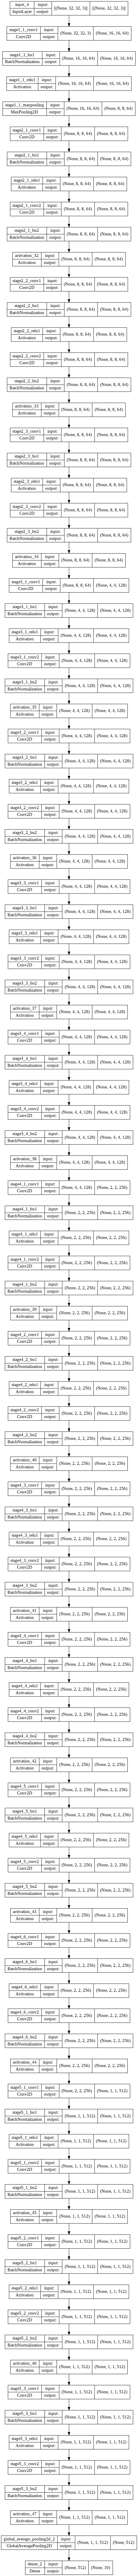

In [ ]:
plot_model(plain_resnet_34, show_shapes=True)

In [ ]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
plain_resnet_50 = build_plain_resnet(is_50=True,num_classes = 10,name="Plain-ResNet50")

plain_resnet_50.summary()

Model: "Plain-ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 stage1_1_conv1 (Conv2D)     (None, 16, 16, 64)        9472      
                                                                 
 stage1_1_bn1 (BatchNormaliz  (None, 16, 16, 64)       256       
 ation)                                                          
                                                                 
 stage1_1_relu1 (Activation)  (None, 16, 16, 64)       0         
                                                                 
 stage1_1_maxpooling (MaxPoo  (None, 8, 8, 64)         0         
 ling2D)                                                         
                                                                 
 stage2_1_conv1 (Conv2D)     (None, 8, 8, 64)       

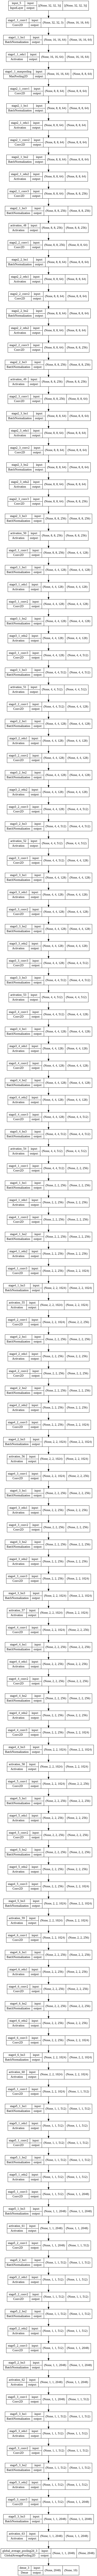

In [ ]:
plot_model(plain_resnet_50, show_shapes=True)

# 모델 학습

In [ ]:
BATCH_SIZE = 32
EPOCH = 20

In [ ]:
def normalize_and_resize_img(image, label): #map에 사용될 함수
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1 #interleaving
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE) #normalization 진행
ds_test = apply_normalize_on_dataset(ds_test,is_test=True, batch_size=BATCH_SIZE)

In [ ]:
resnet_50 = build_resnet(input_shape=(224,224,3),is_50=True,num_classes = 1,activation='sigmoid',name="ResNet50")
resnet_34 = build_resnet(input_shape=(224,224,3),is_50=False,num_classes = 1,activation='sigmoid',name="ResNet34")
plain_resnet_50 = build_plain_resnet(input_shape=(224,224,3),is_50=True,num_classes = 1,activation='sigmoid',name="Plain-ResNet50")
plain_resnet_34 = build_plain_resnet(input_shape=(224,224,3),is_50=False,num_classes = 1,activation='sigmoid',name="Plain-ResNet34")

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

plain_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

plain_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 122s 173ms/step - loss: 1.0995 - accuracy: 0.5344 - val_loss: 0.7071 - val_accuracy: 0.5366
Epoch 2/20
581/581 [==============================] - 99s 171ms/step - loss: 0.6828 - accuracy: 0.5746 - val_loss: 0.6820 - val_accuracy: 0.5914
Epoch 3/20
581/581 [==============================] - 99s 171ms/step - loss: 0.6696 - accuracy: 0.5946 - val_loss: 0.6989 - val_accuracy: 0.5944
Epoch 4/20
581/581 [==============================] - 99s 171ms/step - loss: 0.6634 - accuracy: 0.6043 - val_loss: 0.6839 - val_accuracy: 0.6024
Epoch 5/20
581/581 [==============================] - 100s 171ms/step - loss: 0.6618 - accuracy: 0.6054 - val_loss: 0.7121 - val_accuracy: 0.5991
Epoch 6/20
581/581 [==============================] - 100s 172ms/step - loss: 0.6562 - accuracy: 0.6086 - val_loss: 0.6771 - val_accuracy: 0.6069
Epoch 7/20
581/581 [==============================] - 100s 172ms/step - loss: 0.6563 - accuracy: 0.6106 - val_loss: 0.6622 - va

In [ ]:
history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 71s 106ms/step - loss: 0.8007 - accuracy: 0.5431 - val_loss: 0.6886 - val_accuracy: 0.5565
Epoch 2/20
581/581 [==============================] - 61s 105ms/step - loss: 0.6754 - accuracy: 0.5908 - val_loss: 0.6847 - val_accuracy: 0.6084
Epoch 3/20
581/581 [==============================] - 61s 105ms/step - loss: 0.6587 - accuracy: 0.6091 - val_loss: 0.6688 - val_accuracy: 0.6155
Epoch 4/20
581/581 [==============================] - 61s 105ms/step - loss: 0.6483 - accuracy: 0.6238 - val_loss: 0.6735 - val_accuracy: 0.6231
Epoch 5/20
581/581 [==============================] - 61s 105ms/step - loss: 0.6387 - accuracy: 0.6390 - val_loss: 0.6375 - val_accuracy: 0.6470
Epoch 6/20
581/581 [==============================] - 61s 105ms/step - loss: 0.6307 - accuracy: 0.6450 - val_loss: 0.6377 - val_accuracy: 0.6485
Epoch 7/20
581/581 [==============================] - 61s 106ms/step - loss: 0.6178 - accuracy: 0.6593 - val_loss: 0.6677 - val_ac

In [ ]:
history_50_plain = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 96s 149ms/step - loss: 0.7654 - accuracy: 0.5116 - val_loss: 0.7184 - val_accuracy: 0.5157
Epoch 2/20
581/581 [==============================] - 86s 148ms/step - loss: 0.6934 - accuracy: 0.5106 - val_loss: 0.6964 - val_accuracy: 0.4888
Epoch 3/20
581/581 [==============================] - 86s 148ms/step - loss: 0.6935 - accuracy: 0.5043 - val_loss: 0.6959 - val_accuracy: 0.5175
Epoch 4/20
581/581 [==============================] - 86s 148ms/step - loss: 0.6920 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.5168
Epoch 5/20
581/581 [==============================] - 86s 148ms/step - loss: 0.6923 - accuracy: 0.5056 - val_loss: 0.6954 - val_accuracy: 0.5183
Epoch 6/20
581/581 [==============================] - 86s 148ms/step - loss: 0.6919 - accuracy: 0.5055 - val_loss: 0.6945 - val_accuracy: 0.5179
Epoch 7/20
581/581 [==============================] - 86s 149ms/step - loss: 0.6923 - accuracy: 0.5060 - val_loss: 0.7015 - val_ac

In [ ]:
history_34_plain = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 67s 100ms/step - loss: 0.7183 - accuracy: 0.5023 - val_loss: 0.6986 - val_accuracy: 0.5261
Epoch 2/20
581/581 [==============================] - 58s 100ms/step - loss: 0.6925 - accuracy: 0.5106 - val_loss: 0.6977 - val_accuracy: 0.5224
Epoch 3/20
581/581 [==============================] - 58s 100ms/step - loss: 0.6915 - accuracy: 0.5131 - val_loss: 0.6941 - val_accuracy: 0.5241
Epoch 4/20
581/581 [==============================] - 58s 100ms/step - loss: 0.6910 - accuracy: 0.5121 - val_loss: 0.6936 - val_accuracy: 0.5246
Epoch 5/20
581/581 [==============================] - 58s 100ms/step - loss: 0.6905 - accuracy: 0.5205 - val_loss: 0.6934 - val_accuracy: 0.5263
Epoch 6/20
581/581 [==============================] - 59s 101ms/step - loss: 0.6906 - accuracy: 0.5186 - val_loss: 0.6937 - val_accuracy: 0.5254
Epoch 7/20
581/581 [==============================] - 59s 101ms/step - loss: 0.6902 - accuracy: 0.5198 - val_loss: 0.6938 - val_ac

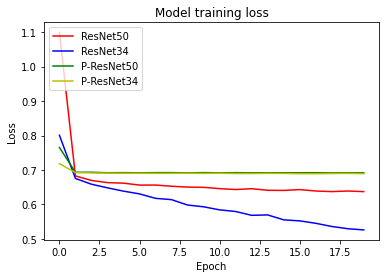

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_50.history['loss'], 'r')
plt.plot(history_34.history['loss'], 'b')
plt.plot(history_50_plain.history['loss'], 'g')
plt.plot(history_34_plain.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet50', 'ResNet34','P-ResNet50','P-ResNet34'], loc='upper left')
plt.show()

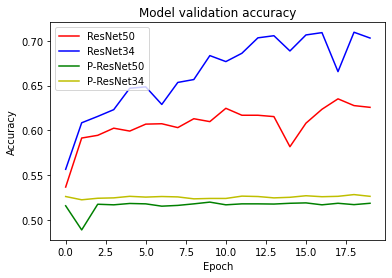

In [ ]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50_plain.history['val_accuracy'], 'g')
plt.plot(history_34_plain.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50', 'ResNet34','P-ResNet50','P-ResNet34'], loc='upper left')
plt.show()

In [ ]:
val_accuracy_50 = np.array(history_50.history['val_accuracy'])
val_accuracy_34 = np.array(history_34.history['val_accuracy'])
val_accuracy_50_plain = np.array(history_50_plain.history['val_accuracy'])
val_accuracy_34_plain = np.array(history_34_plain.history['val_accuracy'])

print(val_accuracy_50.mean(),val_accuracy_34.mean(),val_accuracy_50_plain.mean(),val_accuracy_34_plain.mean())

0.606939646601677 0.6637500017881394 0.5161422476172447 0.5253987073898315


# 회고

처음으로 논문을 읽어봤다.

여러 블로그들을 보며 논문 읽는 방법을 알아봤는데,

다들 논문 읽는 방법에 큰 차이는 없었다.

그래서 나는 (강태님께서 알려주신) Andrew Ng님의 꿀팁(https://medium.com/@mohamedalihabib7/advice-on-building-a-machine-learning-career-and-reading-research-papers-by-prof-andrew-ng-f90ac99a0182)에 나오는 논문 읽는 방법으로 읽어보기로 했다.

다행히 논문에서 무슨 말을 하려는지는 이해했는데, 이 논문을 바탕으로 ResNet을 만들 실력은 되지 않았다.

코드에 손도 못대겠어서 퍼실님께 여쭤봤더니 ResNet은 다른 분들이 짜둔 코드가 많으니 보고 필사를 하며 코드 이해를 하고 스스로 이해한 코드를 만들어 보라고 해서 해봤다.

물론 아직 중간중간 기억나지 않아서 보고 적은 부분도 많았지만 코드를 왜 이렇게 설계했는지는 이해했다.

결과를 보면 내 생각과 조금 다르긴해서 문제가 있는거 아닌가 생각이 들기도 하는데,, 

조금 더 공부를 해봐야겠다,,